# LAB 8: Techniques for training deep neural nets

The purpose of this lab work is to study the most useful techniques for training deep feed-forward neural networks in Keras. In particular the lab illustrates techniques for preventing gradient vanishing and exploding phenomena often encountered in such deep networks, including the use of various activation functions and weight initialisation methods, gradient clipping, as well as the batch normalisation method. To speed up the model training, diferent optimisers are illustrated in this lab, including SGD with mementum, and with the Nesterov trick, and adaptive learning rate optimisers such as RMSProp, ADAM and NADAM. Also, to speed up computation and to help making computation more stable and convergent, particular learning rate scheduling methods are also ilustrated. Finally, since large networks such as deep neural nets are prone to overfitting due to their flexibility based on the large number of parameters they have, the lab illustrates overfiting preventing methods such as L1, L2, Dropout and Maxnorm regularisations. 

## Tasks 
1. Study and run (cell by cell) the code below which illustrates the deep nerual network methods mentioned above. Experiment with the code (including choosing different values for the parameters of training to see what happens).

2. Is it aceptable to initialize all the weights to the same value as long as that value is
selected randomly using He initialization? (See such exercises at the end of Chapter 11 in HoML book - and Appendix A for examples of answers.)

3. Is it acceptable to initialize the bias terms to 0? (See suggestion above)

4. Name three advantages of the SELU activation function over ReLU. (See suggestion above)

5. In which cases would you want to use each of the following activation functions:
SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax? (See suggestion above)

6. What may happen if you set the momentum hyperparameter too close to 1 (e.g.,
 0.99999) when using an SGD optimizer? (See suggestion above)

7. Name three ways you can produce a sparse model. (See suggestion above)

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1 is required
import sklearn
assert sklearn.__version__ >= "1.0"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2024-02-18 13:24:00.821394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 13:24:00.821438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 13:24:00.822576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 13:24:01.950364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_

# Vanishing/Exploding Gradients Problem

In [2]:
# define logistic function

def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


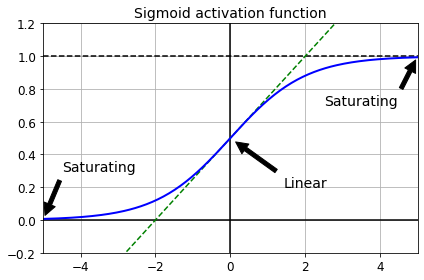

In [3]:
# and plot it, its saturating and linear parts

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [4]:
# here are the posible methods for initialising the weights in a neuarl net

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
# define Leaky ReLU function, which is superior to ReLU, and plot it
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


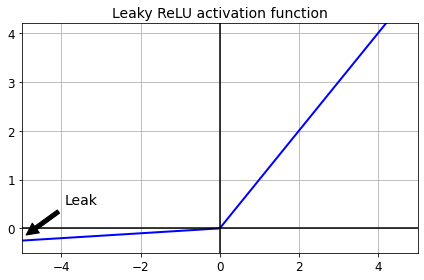

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
# some Keras activations
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
# activation functions in ReLU / LeakyReLU family already defined in Keras
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3123 - accuracy: 0.5994 - val_loss: 0.8804 - val_accuracy: 0.7164
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7883 - accuracy: 0.7419 - val_loss: 0.7106 - val_accuracy: 0.7698
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6775 - accuracy: 0.7765 - val_loss: 0.6449 - val_accuracy: 0.7890
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6193 - accuracy: 0.7962 - val_loss: 0.5899 - val_accuracy: 0.8088
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5815 - accuracy: 0.8069 - val_loss: 0.5589 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5543 - accuracy: 0.8140 - val_loss: 0.5356 - val_accuracy: 0.8242
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5338 - accuracy: 0.8207 - val_loss: 0.5175 - val_accuracy:

Now let's try PReLU:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3168 - accuracy: 0.6112 - val_loss: 0.8933 - val_accuracy: 0.7208
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7996 - accuracy: 0.7487 - val_loss: 0.7116 - val_accuracy: 0.7722
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6815 - accuracy: 0.7825 - val_loss: 0.6399 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6194 - accuracy: 0.7999 - val_loss: 0.5835 - val_accuracy: 0.8092
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5793 - accuracy: 0.8106 - val_loss: 0.5504 - val_accuracy: 0.8170
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5507 - accuracy: 0.8187 - val_loss: 0.5266 - val_accuracy: 0.8252
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5290 - accuracy: 0.8236 - val_loss: 0.5067 - val_accuracy:

### ELU

In [18]:
# define and display the ELU activation fucntion
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


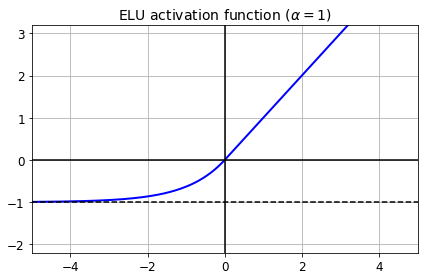

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


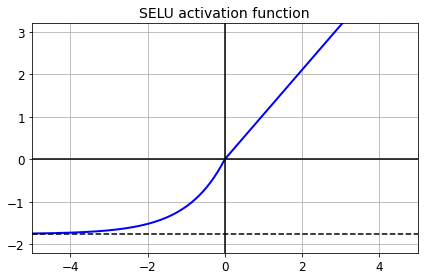

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 40s 19ms/step - loss: 0.9766 - accuracy: 0.6430 - val_loss: 0.7285 - val_accuracy: 0.7398
Epoch 2/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.6787 - accuracy: 0.7569 - val_loss: 0.5886 - val_accuracy: 0.7914
Epoch 3/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.5679 - accuracy: 0.7944 - val_loss: 0.5410 - val_accuracy: 0.8172
Epoch 4/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.5159 - accuracy: 0.8174 - val_loss: 0.4916 - val_accuracy: 0.8308
Epoch 5/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.4802 - accuracy: 0.8321 - val_loss: 0.4603 - val_accuracy: 0.8436


Now look at what happens if we try to use the ReLU activation function instead:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 38s 18ms/step - loss: 2.0080 - accuracy: 0.2306 - val_loss: 1.6238 - val_accuracy: 0.3434
Epoch 2/5
1719/1719 [==============================] - 30s 17ms/step - loss: 1.5521 - accuracy: 0.3924 - val_loss: 1.3059 - val_accuracy: 0.4674
Epoch 3/5
1719/1719 [==============================] - 30s 17ms/step - loss: 1.2133 - accuracy: 0.5346 - val_loss: 0.9108 - val_accuracy: 0.6612
Epoch 4/5
1719/1719 [==============================] - 30s 17ms/step - loss: 1.0715 - accuracy: 0.5909 - val_loss: 1.0800 - val_accuracy: 0.5968
Epoch 5/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.8989 - accuracy: 0.6597 - val_loss: 0.7778 - val_accuracy: 0.6810


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [35]:
# Let's use Bach Normalisation (BN), as a method useful in vanishing/exploding gradients

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [39]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8620 - accuracy: 0.7120 - val_loss: 0.5520 - val_accuracy: 0.8106
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5745 - accuracy: 0.8008 - val_loss: 0.4724 - val_accuracy: 0.8366
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5177 - accuracy: 0.8193 - val_loss: 0.4374 - val_accuracy: 0.8496
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4777 - accuracy: 0.8326 - val_loss: 0.4158 - val_accuracy: 0.8532
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4532 - accuracy: 0.8397 - val_loss: 0.4018 - val_accuracy: 0.8610
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4354 - accuracy: 0.8469 - val_loss: 0.3888 - val_accuracy: 0.8638
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4228 - accuracy: 0.8499 - val_loss: 0.3793 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [42]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.0521 - accuracy: 0.6773 - val_loss: 0.6785 - val_accuracy: 0.7886
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6818 - accuracy: 0.7830 - val_loss: 0.5537 - val_accuracy: 0.8168
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5984 - accuracy: 0.8037 - val_loss: 0.4985 - val_accuracy: 0.8352
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5479 - accuracy: 0.8169 - val_loss: 0.4652 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5128 - accuracy: 0.8259 - val_loss: 0.4422 - val_accuracy: 0.8520
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4918 - accuracy: 0.8299 - val_loss: 0.4244 - val_accuracy: 0.8560
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4739 - accuracy: 0.8391 - val_loss: 0.4112 - val_accuracy:

## Gradient Clipping

A useful method to prevent gradient exploding. All Keras optimizers accept `clipnorm` or `clipvalue` arguments.

In [43]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [44]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

If we don't have enough labeled data to train a Deep Neural Net, then using pretrained layers from another symilar application helps. 

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [45]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [46]:
X_train_A.shape

(43986, 28, 28)

In [47]:
X_train_B.shape

(200, 28, 28)

In [48]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [49]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

In [51]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [52]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [53]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5916 - accuracy: 0.8070 - val_loss: 0.3882 - val_accuracy: 0.8645
Epoch 2/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3561 - accuracy: 0.8774 - val_loss: 0.3281 - val_accuracy: 0.8859
Epoch 3/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3161 - accuracy: 0.8904 - val_loss: 0.2992 - val_accuracy: 0.8976
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2962 - accuracy: 0.8979 - val_loss: 0.2857 - val_accuracy: 0.9051
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2836 - accuracy: 0.9025 - val_loss: 0.2761 - val_accuracy: 0.9086
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2743 - accuracy: 0.9066 - val_loss: 0.2692 - val_accuracy: 0.9073
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2664 - accuracy: 0.9096 - val_loss: 0.2666 - val_accuracy:

In [54]:
model_A.save("my_model_A.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [56]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [57]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 49ms/step - loss: 0.7474 - accuracy: 0.5650 - val_loss: 0.6478 - val_accuracy: 0.6420
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5496 - accuracy: 0.7200 - val_loss: 0.5012 - val_accuracy: 0.7972
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.4244 - accuracy: 0.8650 - val_loss: 0.4084 - val_accuracy: 0.8651
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3437 - accuracy: 0.9200 - val_loss: 0.3413 - val_accuracy: 0.9006
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2838 - accuracy: 0.9400 - val_loss: 0.2929 - val_accuracy: 0.9270
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2402 - accuracy: 0.9500 - val_loss: 0.2566 - val_accuracy: 0.9473
Epoch 7/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2079 - accuracy: 0.9750 - val_loss: 0.2302 - val_accuracy: 0.9533
Epoch 8/20
7/7 [===========

In [58]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [59]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [60]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [62]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 46ms/step - loss: 1.4696 - accuracy: 0.0700 - val_loss: 1.3390 - val_accuracy: 0.1491
Epoch 2/4
7/7 [==============================] - 0s 17ms/step - loss: 1.3390 - accuracy: 0.1050 - val_loss: 1.2220 - val_accuracy: 0.1917
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 1.2207 - accuracy: 0.1750 - val_loss: 1.1158 - val_accuracy: 0.2323
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 1.1137 - accuracy: 0.2100 - val_loss: 1.0182 - val_accuracy: 0.2860
Epoch 1/16
7/7 [==============================] - 1s 47ms/step - loss: 0.8632 - accuracy: 0.4250 - val_loss: 0.6058 - val_accuracy: 0.6694
Epoch 2/16
7/7 [==============================] - 0s 19ms/step - loss: 0.5343 - accuracy: 0.7900 - val_loss: 0.4290 - val_accuracy: 0.8580
Epoch 3/16
7/7 [==============================] - 0s 20ms/step - loss: 0.3827 - accuracy: 0.9300 - val_loss: 0.3299 - val_accuracy: 0.9320
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [63]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.9850


[0.1026170626282692, 0.9850000143051147]

In [64]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9930


[0.08887803554534912, 0.9929999709129333]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.9!

In [65]:
(100 - 97.05) / (100 - 99.40)

4.916666666666718

# Faster Optimizers: 
## good alternatives to simple Gradient Descent

## Momentum optimization

In [66]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [67]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [68]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

In [69]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam Optimization

In [70]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [71]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [72]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling: 
### helping training converge and be more stable by reducing the learning rate according to a scheduling while progressing with epochs

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [73]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-4)

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [75]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4892 - accuracy: 0.8283 - val_loss: 0.4033 - val_accuracy: 0.8620
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3788 - accuracy: 0.8661 - val_loss: 0.3714 - val_accuracy: 0.8720
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3452 - accuracy: 0.8765 - val_loss: 0.3783 - val_accuracy: 0.8680
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3227 - accuracy: 0.8841 - val_loss: 0.3501 - val_accuracy: 0.8752
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3060 - accuracy: 0.8895 - val_loss: 0.3407 - val_accuracy: 0.8760
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2895 - accuracy: 0.8961 - val_loss: 0.3407 - val_accuracy: 0.8800
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2777 - accuracy: 0.9002 - val_loss: 0.3388 - val_accuracy:

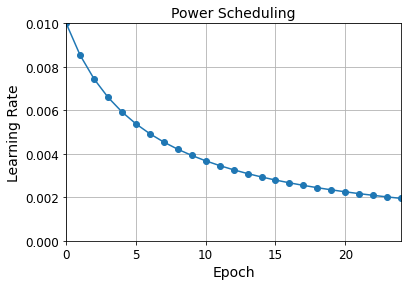

In [76]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [77]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [78]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [79]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [80]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7306 - accuracy: 0.7843 - val_loss: 0.6534 - val_accuracy: 0.8042 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6206 - accuracy: 0.8101 - val_loss: 0.5712 - val_accuracy: 0.8182 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5781 - accuracy: 0.8227 - val_loss: 0.5918 - val_accuracy: 0.8362 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5333 - accuracy: 0.8378 - val_loss: 0.5545 - val_accuracy: 0.8338 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4858 - accuracy: 0.8494 - val_loss: 0.4666 - val_accuracy: 0.8594 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4746 - accuracy: 0.8548 - val_loss: 0.5178 - val_accuracy: 0.8528 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6s

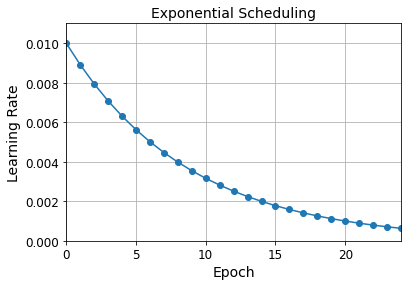

In [81]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [82]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [83]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7179 - accuracy: 0.7867 - val_loss: 0.6470 - val_accuracy: 0.8252 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6158 - accuracy: 0.8128 - val_loss: 0.5596 - val_accuracy: 0.8266 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5599 - accuracy: 0.8293 - val_loss: 0.5873 - val_accuracy: 0.8282 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5115 - accuracy: 0.8421 - val_loss: 0.5065 - val_accuracy: 0.8440 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4752 - accuracy: 0.8523 - val_loss: 0.5121 - val_accuracy: 0.8480 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4267 - accuracy: 0.8662 - val_loss: 0.4945 - val_accuracy: 0.8508 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 7s

In [84]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

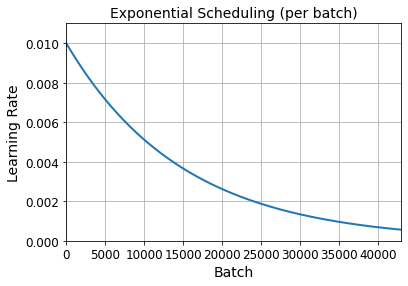

In [85]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [86]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [87]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [88]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7799 - accuracy: 0.7673 - val_loss: 0.6733 - val_accuracy: 0.8072 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7586 - accuracy: 0.7773 - val_loss: 0.8325 - val_accuracy: 0.7822 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8772 - accuracy: 0.7447 - val_loss: 0.8174 - val_accuracy: 0.7440 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.9165 - accuracy: 0.7339 - val_loss: 1.1129 - val_accuracy: 0.7182 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8296 - accuracy: 0.7686 - val_loss: 0.7685 - val_accuracy: 0.7806 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5853 - accuracy: 0.8231 - val_loss: 0.5844 - val_accuracy: 0.8386 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

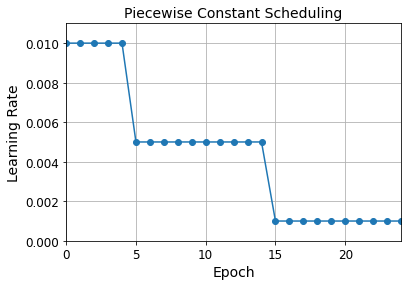

In [89]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [90]:
tf.random.set_seed(42)
np.random.seed(42)

In [91]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5999 - accuracy: 0.8043 - val_loss: 0.5039 - val_accuracy: 0.8500 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4835 - accuracy: 0.8429 - val_loss: 0.6062 - val_accuracy: 0.8298 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5196 - accuracy: 0.8409 - val_loss: 0.5409 - val_accuracy: 0.8418 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5312 - accuracy: 0.8437 - val_loss: 0.4910 - val_accuracy: 0.8542 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5297 - accuracy: 0.8466 - val_loss: 0.5163 - val_accuracy: 0.8492 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5091 - accuracy: 0.8541 - val_loss: 0.6183 - val_accuracy: 0.8512 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 5s

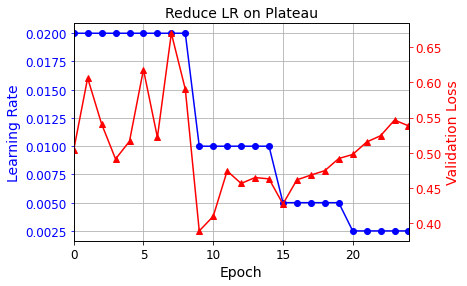

In [92]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [93]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4896 - accuracy: 0.8267 - val_loss: 0.4065 - val_accuracy: 0.8600
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3808 - accuracy: 0.8666 - val_loss: 0.3758 - val_accuracy: 0.8712
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3474 - accuracy: 0.8774 - val_loss: 0.3743 - val_accuracy: 0.8686
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3262 - accuracy: 0.8833 - val_loss: 0.3530 - val_accuracy: 0.8784
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3106 - accuracy: 0.8904 - val_loss: 0.3450 - val_accuracy: 0.8798
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2965 - accuracy: 0.8951 - val_loss: 0.3432 - val_accuracy: 0.8822
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2862 - accuracy: 0.8985 - val_loss: 0.3384 - val_accuracy:

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [94]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [95]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 1.6087 - accuracy: 0.8135 - val_loss: 0.7075 - val_accuracy: 0.8388
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7212 - accuracy: 0.8279 - val_loss: 0.6938 - val_accuracy: 0.8358


In [96]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6100 - accuracy: 0.8137 - val_loss: 0.7066 - val_accuracy: 0.8384
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7231 - accuracy: 0.8261 - val_loss: 0.6934 - val_accuracy: 0.8334


## Dropout regularisation

In [97]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 4ms/step - loss: 0.5706 - accuracy: 0.8032 - val_loss: 0.3594 - val_accuracy: 0.8706
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4253 - accuracy: 0.8437 - val_loss: 0.3533 - val_accuracy: 0.8714


## MC Dropout: useful in improving prediction

In [98]:
tf.random.set_seed(42)
np.random.seed(42)

In [99]:
# ML Dropout consists of applying the trained model 100 times, with Dropout activated, and averaging its predictions.
# It's a useful method to increase the model's performance, and evaluate the standard deviation as a sort of measure of 
# prediction's imprecision.

y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [100]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 89ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.08, 0.  , 0.9 ]],
      dtype=float32)

In [101]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.35, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.06, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.04, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.79, 0.  , 0.21]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.53, 0.  , 0.39]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.12, 0.  , 0.82]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.69]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.13, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.16, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.  , 0.25, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.23, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0

In [102]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.19, 0.  , 0.76]],
      dtype=float32)

In [103]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.2 , 0.  , 0.21]],
      dtype=float32)

In [104]:
y_pred = np.argmax(y_proba, axis=1)

In [105]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8546

## Max norm regularisation

In [106]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [107]:
# We limit the weights in a layer, by imposing a constraint on the L2 norm of vectors of weights to be under
# a threshold, here 1. This diminish the flexibility of the network, so helps preventing overfitting 

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4766 - accuracy: 0.8324 - val_loss: 0.3738 - val_accuracy: 0.8682
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3606 - accuracy: 0.8698 - val_loss: 0.3937 - val_accuracy: 0.8592
